In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz

## Data Modeling Workflow
The following workflow will be applied in building the data model:
1.  Extract tests at assessment and weeks 0 - 4 for treatment<br>
2.  Extract surveys at assessment and weeks 0, 4 for treatment
3.  Extract Other Numeric Baseline Predictors, including:
    - attendence
    - medication dose
    - clinical opiate withdrawal scale - score of 1 - 13, lower score shows lower withdrawal symptoms
4.  Extract Catagorical Baseline Predictors, including:
    - Demographics
    - Substance Use Diagnosis
    - Mental and Pysical Health History
    - Physical Exam

## Load Data

In [2]:
# read csv file
data = pd.read_csv('../data/merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1321, 422)


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,pex_skin,medication,weeks_attended,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,2.0,27,11.0,6.0,2.0,0.0,30.0,0.0,0.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,abnormal,2.0,27,8.0,1.0,3.0,1.0,35.0,0.0,0.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,abnormal,1.0,27,8.0,5.0,3.0,30.0,90.0,0.0,0.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,normal,2.0,27,11.0,9.0,3.0,9.0,44.0,0.0,1.0
4,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,abnormal,2.0,3,11.0,6.0,1.0,0.0,4.0,0.0,26.0


## Review Tests

In [3]:
test_names = [
 #'Propoxyphene',
 #'Amphetamines',
 #'Cannabinoids',
 #'Benzodiazepines',
 #'MMethadone',
 #'Oxycodone',
 #'Cocaine',
 #'Methamphetamine',
 'Opiate300'
 ]

# define prefix parameter and call helper function to build the dataset
prefix = 'test_'
tests = helper.feature_selection(data, prefix, test_names)


Shape of tests DataFrame: (1321, 5)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0
1317,1.0,1.0,1.0,1.0,1.0
1318,1.0,1.0,1.0,1.0,1.0
1319,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [4]:
# comment out the drugs you don't want to include
survey_names = [
#'cannabis',
#'cocaine',
#'alcohol',
#'oxycodone',
#'mmethadone',
#'amphetamine',
#'methamphetamine',
'opiates',
#'benzodiazepines'
]

# call helper function to build  the dataset
prefix = 'survey_'
surveys = helper.feature_selection(data, prefix, survey_names)

Shape of tests DataFrame: (1321, 2)


,survey_opiates_0,survey_opiates_4
0,30.0,0.0
1,30.0,5.0
2,30.0,9.0
3,30.0,6.0
4,5.0,0.0
...,...,...
1316,20.0,0.0
1317,0.0,0.0
1318,30.0,0.0
1319,30.0,0.0


## Create Dataframe for Baseline Numeric Predictors

In [5]:
# medication data, included up to week 4
group = 'meds_'
meds = data[[col for col in data.columns if group in col]].iloc[:, :10]

# clinical opiate withdrawal scale -  included for assessment
cows = data[[col for col in data.columns if 'cows' in col]]

# rbs - risk behavior survey data
rbs = data[[col for col in data.columns if 'rbs' in col]]

# combine all the dataframes
num_df = pd.concat([tests, surveys, meds, cows, rbs], axis=1)
print('Shape of numeric dataframe after feature selection:', num_df.shape)


Shape of numeric dataframe after feature selection: (1321, 24)


## Review Categorical Data

In [6]:
# addiction diagnosis
dsm = data[[col for col in data.columns if col.startswith('dsm_')]]
# medical and psychiatric history
mdh = data[[col for col in data.columns if col.startswith('mdh_')]]
# physical exam
pex = data[[col for col in data.columns if col.startswith('pex_')]]


# concat cat features into cat_df
cat_df = pd.concat([dsm, mdh, pex], axis=1)
print('shape of the categorical df:',cat_df.shape)
display(cat_df)

shape of the categorical df: (1321, 36)


,dsm_cannabis,dsm_cocaine,dsm_sedative,dsm_opiates,dsm_alcohol,dsm_amphetamine,mdh_liver_problems,mdh_kidney_problems,mdh_alc_withdrawal,mdh_schizophrenia,...,pex_respiratory,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin
0,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,yes_history,no_history,no_history,no_history,...,normal,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal
1,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,abnormal,normal,normal,abnormal,abnormal,normal,normal,abnormal
2,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,abnormal
3,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
4,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,abnormal,abnormal,normal,abnormal,abnormal,normal,normal,abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
1317,not_present,not_present,not_present,not_present,not_present,not_present,yes_history,no_history,no_history,no_history,...,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated
1318,no_diagnosis,dependence,no_diagnosis,dependence,abuse,no_diagnosis,no_history,no_history,yes_history,no_history,...,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal,normal
1319,abuse,dependence,no_diagnosis,dependence,no_diagnosis,dependence,no_history,no_history,no_history,no_history,...,normal,normal,normal,abnormal,normal,normal,normal,normal,normal,abnormal


## One Hot Encode Categorical Data

In [27]:
# one hot encode cat df
cat_df = pd.get_dummies(cat_df, drop_first=True, dtype=int)

cat_df

,dsm_cannabis_abuse,dsm_cannabis_dependence,dsm_cannabis_no_diagnosis,dsm_cannabis_not_present,dsm_cocaine_abuse,dsm_cocaine_dependence,dsm_cocaine_no_diagnosis,dsm_cocaine_not_present,dsm_sedative_abuse,dsm_sedative_dependence,...,pex_head_neck_not_evaluated,pex_head_neck_not_present,pex_cardio_abnormal,pex_cardio_normal,pex_cardio_not_evaluated,pex_cardio_not_present,pex_skin_abnormal,pex_skin_normal,pex_skin_not_evaluated,pex_skin_not_present
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1317,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
1318,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1319,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


## Assign Target Variable and Merge

In [7]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, cat_df, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (1321, 61)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,normal,abnormal,normal,normal,abnormal,abnormal,normal,normal,abnormal,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,normal,normal,normal,normal,normal,normal,normal,normal,abnormal,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,normal,abnormal,abnormal,normal,abnormal,abnormal,normal,normal,abnormal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,1.0,1.0,1.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,1.0
1317,1.0,1.0,1.0,1.0,1.0,0.0,0.0,150.0,0.0,0.0,...,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,1.0
1318,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,...,abnormal,normal,normal,normal,normal,normal,normal,normal,normal,1.0
1319,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,2.0,0.0,...,normal,normal,abnormal,normal,normal,normal,normal,normal,abnormal,1.0


In [8]:
new_data.to_csv('../data/benchmark_features.csv', index=False)

## Classification Workflow

In [30]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np


# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.15
validation = 0.15
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(new_data,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (924, 148)
Shape of X_val: (198, 148)
Shape of X_test: (199, 148)


In [31]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=5, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'objective': 'binary:logistic'}
Highest ROC AUC found:  0.9065999987856486


In [32]:
# refit the model with the best params
best_params = grid_auc.best_params_

# best model
best_gbm = xgb.XGBClassifier(**best_params)

# fit the model
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

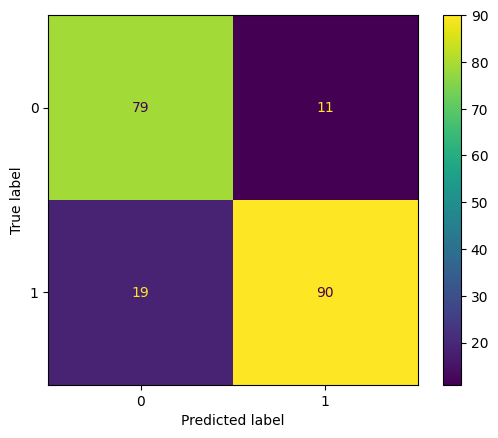

In [33]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

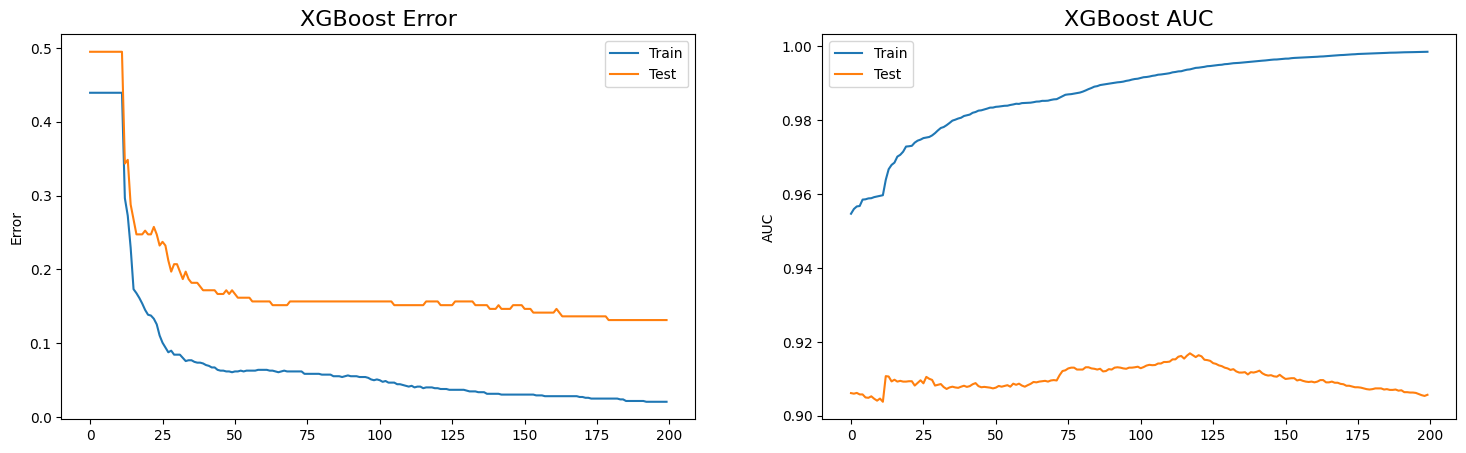

In [34]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [35]:
# make predictions to evaluate the model
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

### Create DF with Train, Val and Test metrics

In [36]:
from sklearn.metrics import classification_report

# Assuming you have your predictions as y_pred_train, y_pred_val, y_pred_test
# and the true labels as y_train, y_val, y_test

# Generate classification reports
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_val = classification_report(y_val, y_pred_val, output_dict=True)
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Create DataFrames from reports
df_train = pd.DataFrame(report_train).transpose()
df_val = pd.DataFrame(report_val).transpose()
df_test = pd.DataFrame(report_test).transpose()

# Add a column to distinguish between datasets
df_train['dataset'] = 'Training'
df_val['dataset'] = 'Validation'
df_test['dataset'] = 'Test'

# Concatenate all three DataFrames
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index()

# Rename 'index' column to something more descriptive, like 'metric'
df_all.rename(columns={'index': 'metric'}, inplace=True)

# subset columns
#df_all = df_all[['metric','precision','dataset']]

# pivot the dataframe
#df_all = df_all.pivot(index='dataset', columns='metric', values='precision').reset_index()

# reorder rows, 1, 2, 0
#df_all = df_all.reindex([1,2,0])

classification_metrics = df_all.loc[
                                    (df_all['metric']=='0.0') | 
                                    (df_all['metric']=='1.0') |
                                    (df_all['metric']=='macro avg')    
                                ]

classification_metrics

,metric,precision,recall,f1-score,support,dataset
0,0.0,0.966265,0.987685,0.976857,406.0,Training
1,1.0,0.990177,0.972973,0.981500,518.0,Training
3,macro avg,0.978221,0.980329,0.979179,924.0,Training
5,0.0,0.846154,0.897959,0.871287,98.0,Validation
6,1.0,0.893617,0.840000,0.865979,100.0,Validation
8,macro avg,0.869885,0.868980,0.868633,198.0,Validation
10,0.0,0.806122,0.877778,0.840426,90.0,Test
11,1.0,0.891089,0.825688,0.857143,109.0,Test
13,macro avg,0.848606,0.851733,0.848784,199.0,Test


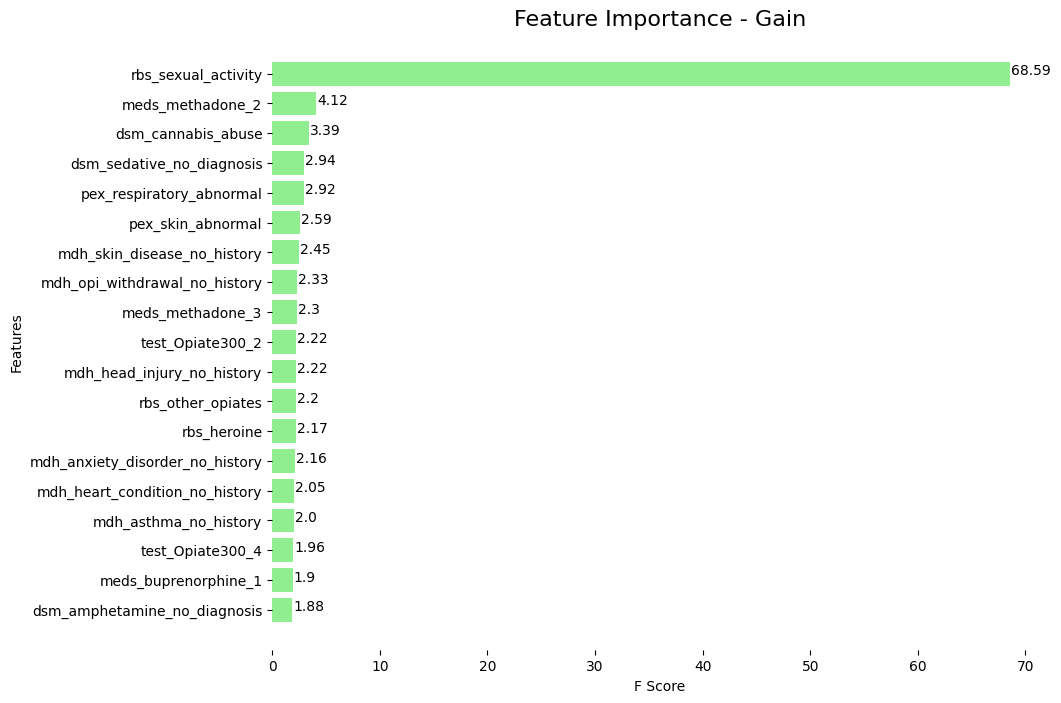

In [37]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming grid_auc.best_estimator_ is your trained XGBoost model
model = grid_auc.best_estimator_

metric='gain'
plot = metric.capitalize().replace('_g', ' G')
#f = 19  # Number of features to plot

# Get feature importances and round them
importances = model.get_booster().get_score(importance_type=metric)
importances_rounded = {k: round(v, 2) for k, v in importances.items()}

# Sort features by importance
sorted_importances = sorted(importances_rounded.items(), key=lambda x: x[1], reverse=True)[:19]

# Separate keys and values for plotting
features, scores = zip(*sorted_importances)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(scores)), scores, color='lightgreen')
plt.yticks(range(len(scores)), features)
plt.xlabel('F Score')
plt.ylabel('Features')
# annotate the values over the bars
for i, v in enumerate(scores):
    plt.text(v + 0.1, i - 0.1, str(v), color='black', va='center')
plt.title(f'Feature Importance - {plot}', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

In [38]:
# show the first element of all rows in the tuple
features = [x[0] for x in sorted_importances]

final_predictors = new_data[features+['dropout']]

#final_predictors = final_predictors.drop(columns=['rbs_sexual_activity'])

print(final_predictors.shape)
display(final_predictors)

(1321, 20)


,rbs_sexual_activity,meds_methadone_2,dsm_cannabis_abuse,dsm_sedative_no_diagnosis,pex_respiratory_abnormal,pex_skin_abnormal,mdh_skin_disease_no_history,mdh_opi_withdrawal_no_history,meds_methadone_3,test_Opiate300_2,mdh_head_injury_no_history,rbs_other_opiates,rbs_heroine,mdh_anxiety_disorder_no_history,mdh_heart_condition_no_history,mdh_asthma_no_history,test_Opiate300_4,meds_buprenorphine_1,dsm_amphetamine_no_diagnosis,dropout
0,2.0,0.0,0,1,0,0,1,0,0.0,0.0,1,0.0,30.0,0,1,1,0.0,160.0,1,0.0
1,3.0,0.0,0,1,0,1,0,1,0.0,1.0,1,0.0,35.0,1,1,1,1.0,48.0,1,0.0
2,3.0,310.0,0,1,0,1,0,0,420.0,1.0,1,0.0,90.0,1,1,1,1.0,0.0,1,0.0
3,3.0,0.0,0,1,0,0,1,0,0.0,0.0,1,1.0,44.0,0,1,1,1.0,152.0,1,0.0
4,1.0,0.0,0,1,0,1,1,0,0.0,1.0,1,26.0,4.0,0,1,1,1.0,16.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,1.0,0.0,0,1,0,0,1,0,0.0,1.0,1,0.0,30.0,0,1,0,1.0,0.0,1,1.0
1317,96.0,0.0,0,0,0,0,0,0,0.0,1.0,1,0.0,0.0,0,1,1,1.0,0.0,0,1.0
1318,1.0,0.0,0,1,1,0,1,0,0.0,1.0,1,0.0,30.0,0,1,1,1.0,0.0,1,1.0
1319,1.0,0.0,1,1,0,1,1,0,0.0,1.0,1,0.0,30.0,1,1,1,1.0,0.0,0,1.0


In [39]:
# sort columns alphabetically
final_predictors = final_predictors.reindex(sorted(final_predictors.columns), axis=1)

final_predictors.columns

Index(['dropout', 'dsm_amphetamine_no_diagnosis', 'dsm_cannabis_abuse',
       'dsm_sedative_no_diagnosis', 'mdh_anxiety_disorder_no_history',
       'mdh_asthma_no_history', 'mdh_head_injury_no_history',
       'mdh_heart_condition_no_history', 'mdh_opi_withdrawal_no_history',
       'mdh_skin_disease_no_history', 'meds_buprenorphine_1',
       'meds_methadone_2', 'meds_methadone_3', 'pex_respiratory_abnormal',
       'pex_skin_abnormal', 'rbs_heroine', 'rbs_other_opiates',
       'rbs_sexual_activity', 'test_Opiate300_2', 'test_Opiate300_4'],
      dtype='object')

### Reverse the dummy variables to prepare the data for ML Pipelines

In [40]:
ohe_columns = ['dsm_alcohol_abuse',
               'dsm_cannabis_abuse', 
               'dsm_cannabis_no_diagnosis', 
               'dsm_sedative_abuse']

final_predictors['dsm'] = final_predictors[ohe_columns].idxmax(axis=1).str.replace('dsm_', '')

final_predictors = final_predictors.drop(columns=ohe_columns)

final_predictors

KeyError: "['dsm_alcohol_abuse', 'dsm_cannabis_no_diagnosis', 'dsm_sedative_abuse'] not in index"

In [ ]:
mdh_columns = ['mdh_anxiety_disorder_yes_history',
       'mdh_major_depressive_disorder_no_history']

final_predictors['mdh'] = final_predictors[mdh_columns].idxmax(axis=1).str.replace('mdh_', '')

final_predictors = final_predictors.drop(columns=mdh_columns)

final_predictors

In [ ]:
pex_columns = ['pex_gi_system_abnormal', 'pex_skin_abnormal']

final_predictors['pex'] = final_predictors[pex_columns].idxmax(axis=1).str.replace('pex_', '')

final_predictors = final_predictors.drop(columns=pex_columns)

final_predictors

In [ ]:
final_predictors.to_csv('../data/final_predictors.csv', index=False)

In [ ]:
# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.15
validation = 0.15
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(final_predictors,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

In [ ]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=5, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

In [ ]:
# refit the model with the best params
best_params = grid_auc.best_params_

# best model
best_gbm = xgb.XGBClassifier(**best_params)

# fit the model
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

In [ ]:
# make predictions to evaluate the model
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

In [ ]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have your predictions as y_pred_train, y_pred_val, y_pred_test
# and the true labels as y_train, y_val, y_test

# Generate classification reports
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_val = classification_report(y_val, y_pred_val, output_dict=True)
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Create DataFrames from reports
df_train = pd.DataFrame(report_train).transpose()
df_val = pd.DataFrame(report_val).transpose()
df_test = pd.DataFrame(report_test).transpose()

# Add a column to distinguish between datasets
df_train['dataset'] = 'Training'
df_val['dataset'] = 'Validation'
df_test['dataset'] = 'Test'

# Concatenate all three DataFrames
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index()

# Rename 'index' column to something more descriptive, like 'metric'
df_all.rename(columns={'index': 'metric'}, inplace=True)

# subset columns
#df_all = df_all[['metric','precision','dataset']]

# pivot the dataframe
#df_all = df_all.pivot(index='dataset', columns='metric', values='precision').reset_index()

# reorder rows, 1, 2, 0
#df_all = df_all.reindex([1,2,0])

classification_metrics = df_all.loc[
                                    (df_all['metric']=='0.0') | 
                                    (df_all['metric']=='1.0') |
                                    (df_all['metric']=='macro avg')    
                                ]

classification_metrics

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming grid_auc.best_estimator_ is your trained XGBoost model
model = grid_auc.best_estimator_

metric='total_gain'
plot = metric.capitalize().replace('_g', ' G')

# Get feature importances and round them
importances = model.get_booster().get_score(importance_type=metric)
importances_rounded = {k: round(v, 2) for k, v in importances.items()}

# Sort features by importance
sorted_importances = sorted(importances_rounded.items(), key=lambda x: x[1], reverse=True)

# Separate keys and values for plotting
features, scores = zip(*sorted_importances)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(scores)), scores, color='lightgreen')
plt.yticks(range(len(scores)), features)
plt.xlabel('F Score')
plt.ylabel('Features')
# annotate the values over the bars
for i, v in enumerate(scores):
    plt.text(v + 0.1, i - 0.1, str(v), color='black', va='center')
plt.title(f'Feature Importance - {plot}', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

## Create a DF with all the trees

In [ ]:
# Assuming `grid_auc` is your trained GridSearchCV object with an XGBClassifier
best_model = grid_auc.best_estimator_

# Extract the Booster
booster = best_model.get_booster()

# Convert the trees to a DataFrame
trees_df = booster.trees_to_dataframe().iloc[:, :10]

trees_df = trees_df.sort_values(by='Gain', ascending=False)

In [ ]:
trees_df.loc[trees_df['Feature'] == 'cows_postdose']

In [ ]:
trees_df.loc[trees_df.Feature == 'rbs_sexual_activity']

## Plot a Specific Estimator


In [ ]:
# plot tree with to_graphviz() sideways
graph = xgb.to_graphviz(booster, num_trees=151)
graph

## Analyze Test Set with Predictions

In [ ]:
# Assuming `model` is your trained model and `X_test`, `y_test` are your test datasets
predictions = best_gbm.predict(X_test)

# Convert X_test to a DataFrame if it's not already
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add predictions and actual labels to the DataFrame
X_test_df['Prediction'] = predictions
X_test_df['Actual'] = y_test

# Function to classify each prediction
def classify_prediction(row):
	if row['Prediction'] == row['Actual']:
		return 'TP' if row['Prediction'] == 1 else 'TN'
	else:
		return 'FP' if row['Prediction'] == 1 else 'FN'

# Apply the function to classify predictions
X_test_df['Classification'] = X_test_df.apply(classify_prediction, axis=1)

# Now X_test_df includes the test data, predictions, actual labels, and classification (TP, TN, FP, FN)
test_df = X_test_df

In [ ]:
# sort columns alphabetically
test_df = test_df.reindex(sorted(test_df.columns), axis=1)

test_df.columns.tolist()

In [ ]:
# save the test_df to a csv file
test_df.to_csv('../data/benchmark_df.csv', index=False)